In [1]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import os
from sklearn.metrics import mean_squared_error

In [2]:
# EEG channels (AUX_1 == EMG)
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2','AUX_1', 'ACC_X', 'ACC_Y', 'ACC_Z']

# Electrodes removed from EEG
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# Eye Tracker channels
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']

# Add both channel names to colums for use in DataFrame later
columns =  eye_data_names + channels


In [3]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False
    # Loops list of timestamps, if there is a value for old value n, where the new value is n + 1, continue, if not, then
    # The start of the list is the start of the blink, then the last value where n + 1 is valid, is the end of the blink
    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

In [4]:
"""
Plots a single EEG channel and Eye Tracking data with normalisation for better plot view
"""
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y)
    peaks = [peak for peak in peaks]


    axis.plot(df_ts['time'][start-rang:end+rang], y, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    for i in peaks:
        plt.plot(df_ts['time'][i+ start - rang], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(round(y[i])) + ", " + str(i+ start - rang))
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Amplitude ")
    axis.set_title(column)
    plt.legend()
    plt.show()
"""
Plots a single EEG channel and Eye Tracking data

"""
def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    axis.plot(df_ts['time'][start-rang:end+rang], df[column], label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], df['left_openness'], color='orange', label = "Eye openness left - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], df['right_openness'], color='violet', label = "Eye openness right - SRanipal")
    axis.set_title(column)
    plt.legend()
    plt.show()

In [5]:
from scipy.signal import resample

"""
Inits the stream data. Used to get a dataframe with the eye tracking data, and the eeg data for easier data processing
"""
def init_data(data, shift = 0):
    streams = []
    for s in data:
        for t in s:
            streams.append(t)

    #Resample
    resample_ = True
    signal_resampled = streams[1]['time_series']
    df_stream = pd.concat([pd.DataFrame(streams[0]['time_series']), pd.DataFrame(signal_resampled)], axis=1)
    df_stream_ts = pd.DataFrame(streams[0]['time_stamps'])
    df_stream_ts.columns = ['time']
    df_stream.columns = columns
    df_stream['AUX_1'] = df_stream['AUX_1']+ 1000000
    if shift != 0:
        df_stream['AUX_1'] = df_stream['AUX_1'].shift(shift)
    df_stream.dropna(inplace=True)
    df_stream_ts.dropna(inplace=True)
    return streams, df_stream, df_stream_ts

"""
Returns a list of indexes where the user blinked with the left eye, right eye and both eyes
"""
def get_blinks_in_df(df):
    left_blinks = df.index[(df['left_blink'] >= 1) & (df['right_blink'] != 1)].tolist()
    right_blinks = df.index[(df['right_blink'] >= 1) & (df['left_blink'] != 1)].tolist()
    both_blink = df.index[df['both_blink'] == 1].tolist()
    #both_blink = df.index[(df['right_openness'] <= 0.1) & (df['left_openness'] <= 0.1)].tolist()
    return left_blinks,right_blinks, both_blink


In [6]:
# Same as EMG channel
chosen_channel = 'AUX_1'


In [7]:
"""
If there are multiple peaks in a curve, take the mean point to ensure best accuracy
"""
def find_close_values_mean(values,y, tolerance):
    values.sort()
    peak = values[np.argmax([y[i] for i in values])]
    # Loop list and compare elements
    for i in range(len(values) - 1):
        if abs(values[i] - peak) <= tolerance and values[i] != peak:
            # Return mean if two values are close
            return (values[i] + values[i + 1]) / 2

    return peak
"""
Return peaks in signal in specified range and normalizes data before finding peak
"""
def get_peaks(df, start, end, column, rang=50, scale=1, flip=False):
    df = df[start - rang:end + rang]
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y)
    peaks = [peak for peak in peaks]
    if len(peaks) == 0:
        #print(df)
        return 0

    peak = find_close_values_mean(peaks, y, 20)+ start - rang
    return  peak



In [8]:
"""
Find the mean shift in the data for best synchronization between EEG and EYE Tracker
"""
def find_shift(start, peaks):
    differences_start = []
    for i in range(len(peaks)):
        differences_start.append(start[i]-peaks[i])
    return differences_start


In [9]:

"""
Method to apply a zero-phase Butterworth filter to the data
Uses bandpass [0.75-5], and order 4
"""
def zero_phase_butter(data):
    # Butterworth filter parameters
    fs = 250
    lowcut =0.75
    highcut = 5.0
    order = 4

    # Design Butterworth bandpass filter
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b_bandpass, a_bandpass = signal.butter(order, [low, high], btype="band")

    # Zero-phase filtering using filtfilt
    return signal.filtfilt(b_bandpass, a_bandpass, data)

"""
Method to import files with EEG and Eye Tracker data, and make them into common DataFrame for easier analysis
"""

def run_files(paths, path='data/LSLGoodData/', both = True, plot = False, shift_init=0):
    t = True
    peak_info = []
    avg_time = []
    for (index,y) in enumerate(paths):
        #data_eeg, header = pyxdf.load_xdf(path+str(y)+'/dejittered-filtered-eeg.xdf')
        #data_eye, header = pyxdf.load_xdf(path+str(y)+'/dejittered-filtered-eye-tracking.xdf')

        #data_eeg, header = pyxdf.load_xdf(path+str(y)+'/dejittered-iir-3order-0.75to5-eeg.xdf')
        data_eeg, header = pyxdf.load_xdf(path+str(y)+'/decimated-dejittered-eeg.xdf')

        data_eye, header = pyxdf.load_xdf(path+str(y)+'/dejittered-gaze-and-blinking.xdf')

        stream, df_stream, df_stream_ts = init_data([data_eye, data_eeg],shift_init)

        # Adding butterworth
        df_stream['AUX_1'] = zero_phase_butter(df_stream['AUX_1'])

        left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)
        start, end = get_time_stamps(both_blink)
        avg_time.append(np.diff(df_stream_ts.to_numpy().flatten()).tolist())

        peaks = []
        # Finding the 10 blinks done in testing
        for i in range(len(start)):
            if i == 10:
                break
            peaks.append(get_peaks(df_stream, start[i], end[i], chosen_channel, rang=50, scale=100, flip=both))

        # Finding the mean shift based on the ten blinks
        shift = find_shift(start, peaks)
        # Adding the shift to info for later use and comparison
        peak_info.append(shift)


    n = len(max(peak_info, key=len))
    # Make empty list of peaks for later adding
    t = [x + [None]*(n-len(x)) for x in peak_info]
    # Make array with peak info
    numpy_array_peak_info = np.array(t)
    df_peak = pd.DataFrame(numpy_array_peak_info)
    df_peak = df_peak.set_index([paths])
    # Add time between index column in dataframe with average time between indexes
    df_peak['time between index (s)'] = [i[0] for i in avg_time]
    # Add sum of indexes column
    df_peak['Sum (indexes)'] = df_peak.sum(axis=1)
    # Add avg indexes column based on the average indexes to shift in rows
    df_peak['Avg (indexes)'] = round(df_peak.loc[:, 0:9].mean(axis=1),3)
    # Add average time shift, where time is multiplied with time between indexes
    df_peak['Avg time (ms)'] = round(df_peak['Avg (indexes)']*df_peak['time between index (s)'],5)*1000
    return df_peak



In [10]:
path = "./data/LSLData--17-04_samlet_alle/"
paths = [name for name in os.listdir(path)]
both = [name for name in paths]
flip = False

df_both = run_files(both,path=path, both=flip , plot=False)
display(df_both)


,0,1,2,3,4,5,6,7,8,9,time between index (s),Sum (indexes),Avg (indexes),Avg time (ms)
LSLData--17-04_2-1,-10,-17,-16,-16,-17,-18,-11,-17,-18,-17,0.004,-156.996,-15.7,-62.8
LSLData--17-04_2-6,-17,-17,-15,-21,-19,-20,-16,-20,-16,-14,0.004,-174.996,-17.5,-70.0
LSLData--17-04_2-14,-12,-15,-11,-12,-13,-11,-11,-12,-11,-18,0.004,-125.996,-12.6,-50.4
LSLData--17-04-8,-16,-16,-16,-16,-22,-8,-12,-15,-14,-13,0.004,-147.996,-14.8,-59.2
LSLData--17-04_2-11,-14,-13,-10,-13,-20,-11,-18,-14,-22,-16,0.004,-150.996,-15.1,-60.4
LSLData--17-04-10,-19,-21,-18,-14,-18,-11,-18,-17,-18,-20,0.004,-173.996,-17.4,-69.6
LSLData--17-04_2-3,-17,-14,-20,-23,-18,-16,-24,-18,-18,-19,0.004,-186.996,-18.7,-74.8
LSLData--17-04-11,-9,-15,-14,-15,-15,-12,-14,-12,-13,-11,0.004,-129.996,-13.0,-52.0
LSLData--17-04_2-5,-18,-15,-18,-17,-9,-15,-11,-8,-13,-12,0.004,-135.996,-13.6,-54.4
LSLData--17-04_2-13,-20,-22,-19,-15,-19,-16,-27,-19,-19,-21,0.004,-196.996,-19.7,-78.8


In [11]:
# Returns average offset in entire dataset
def get_offset(df):
    avg_offset = df['Avg time (ms)'].sum()/df.shape[0]
    avg_offset_index = df['Avg (indexes)'].sum()/df.shape[0]
    return avg_offset, avg_offset_index



In [12]:
print("(Seconds, Number of indexes to shift) ---- Both")
print(get_offset(df_both))

# Run files again, but compensates the found offset
df_both_shift = run_files(both,path = path, both=flip , plot=False, shift_init=round(get_offset(df_both)[1]))
display(df_both_shift)

print(get_offset(df_both_shift))


(Seconds, Number of indexes to shift) ---- Both
(-60.980000000000004, -15.245000000000001)


,0,1,2,3,4,5,6,7,8,9,time between index (s),Sum (indexes),Avg (indexes),Avg time (ms)
LSLData--17-04_2-1,5,-2,-1,-1,-2,-3,4,-2,-3,-2,0.004,-6.996,-0.7,-2.8
LSLData--17-04_2-6,-2,-2,0,-6,-4,-5,-1,-5,-1,1,0.004,-24.996,-2.5,-10.0
LSLData--17-04_2-14,3,0,4,3,2,4,4,3,4,-3,0.004,24.004,2.4,9.6
LSLData--17-04-8,-1,-1,-1,-1,-7,7,3,0,1,2,0.004,2.004,0.2,0.8
LSLData--17-04_2-11,1,2,5,2,-5,4,-3,1,-7,-1,0.004,-0.996,-0.1,-0.4
LSLData--17-04-10,-4,-6,-3,1,-3,4,-3,-2,-3,-5,0.004,-23.996,-2.4,-9.6
LSLData--17-04_2-3,-2,1,-5,-8,-3,-1,-9,-3,-3,-4,0.004,-36.996,-3.7,-14.8
LSLData--17-04-11,6,0,1,0,0,3,1,3,2,4,0.004,20.004,2.0,8.0
LSLData--17-04_2-5,-3,0,-3,-2,6,0,4,7,2,3,0.004,14.004,1.4,5.6
LSLData--17-04_2-13,-5,-7,-4,0,-4,-1,-12,-4,-4,-6,0.004,-46.996,-4.7,-18.8


(-0.9799999999999999, -0.24499999999999997)


In [13]:
import statistics
from scipy.stats import sem
# Finding STD, SE and Mean
standard_de_both = statistics.stdev(df_both['Avg time (ms)'])
se_both = sem(df_both['Avg time (ms)'])
mean = statistics.mean(df_both['Avg time (ms)'])

print("Standard devation (ms) -----")
print("Both: " + str(standard_de_both))

print("-------- SE (ms) ----------")
print("Both: " + str(se_both))


Standard devation (ms) -----
Both: 9.327243627364439
-------- SE (ms) ----------
Both: 2.0856350793488603


In [14]:
# Finding STD, SE and Mean

standard_de_both_shift = statistics.stdev(df_both_shift['Avg time (ms)'])
se_both_shift = sem(df_both_shift['Avg time (ms)'])
mean = statistics.mean(df_both_shift['Avg time (ms)'])

print("Standard devation (ms) - After shift")
print("Both: " + str(standard_de_both_shift))


print("-------- SE (ms) - After shift ----------")
print("Both: " + str(se_both_shift))


Standard devation (ms) - After shift
Both: 9.327243627364439
-------- SE (ms) - After shift ----------
Both: 2.0856350793488603


[-0.188, -0.14800000000000002, -0.1, -0.1, -0.096, -0.06, -0.052000000000000005, -0.04, -0.04, -0.027999999999999997, -0.004, 0.004, 0.008, 0.044000000000000004, 0.055999999999999994, 0.08, 0.084, 0.096, 0.12, 0.168]


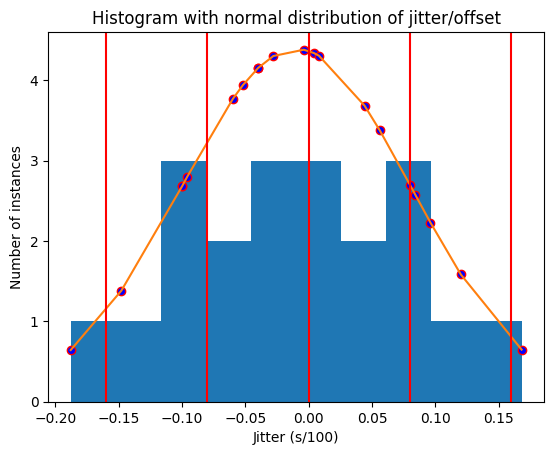

In [15]:
from scipy.stats import norm
# Plot between -10 and 10 with .001 steps.
x_axis = sorted((df_both_shift['Avg time (ms)']/100).tolist())
print(x_axis)

# Plots a histogram with normal distribution and red lines to mark the indexes, to present jitter data
plt.hist(x_axis)
for i in range(len(x_axis)):
    plt.plot(x_axis[i],  norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis))[i], marker="o", markersize=6, markeredgecolor="red", markerfacecolor="blue")
index_secs = 0.08
plt.plot(x_axis, norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis)))
plt.axvline(x=0, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=-index_secs, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=-index_secs*2, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=index_secs, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=index_secs*2, ymax=6, ymin=0, color='r', linestyle='-')
plt.title("Histogram with normal distribution of jitter/offset")
plt.xlabel("Jitter (s/100)")
plt.ylabel("Number of instances")
plt.show()

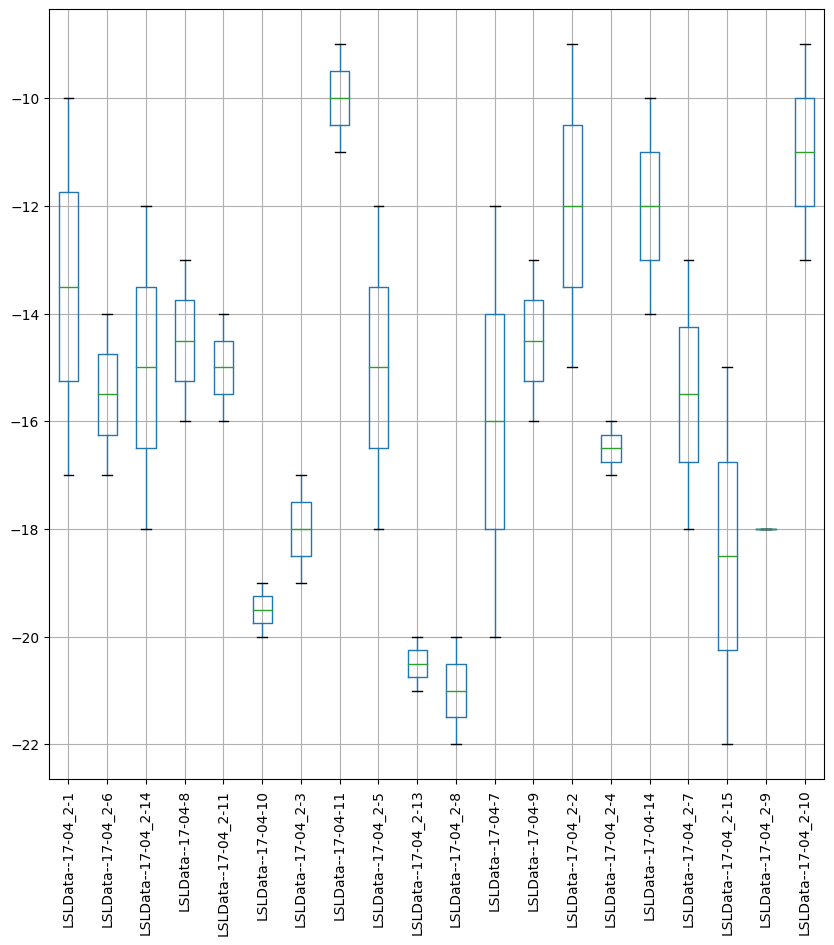

In [16]:

boxplot = df_both.iloc[:, [0, 9]].T.boxplot(figsize=(10,10), rot=90)

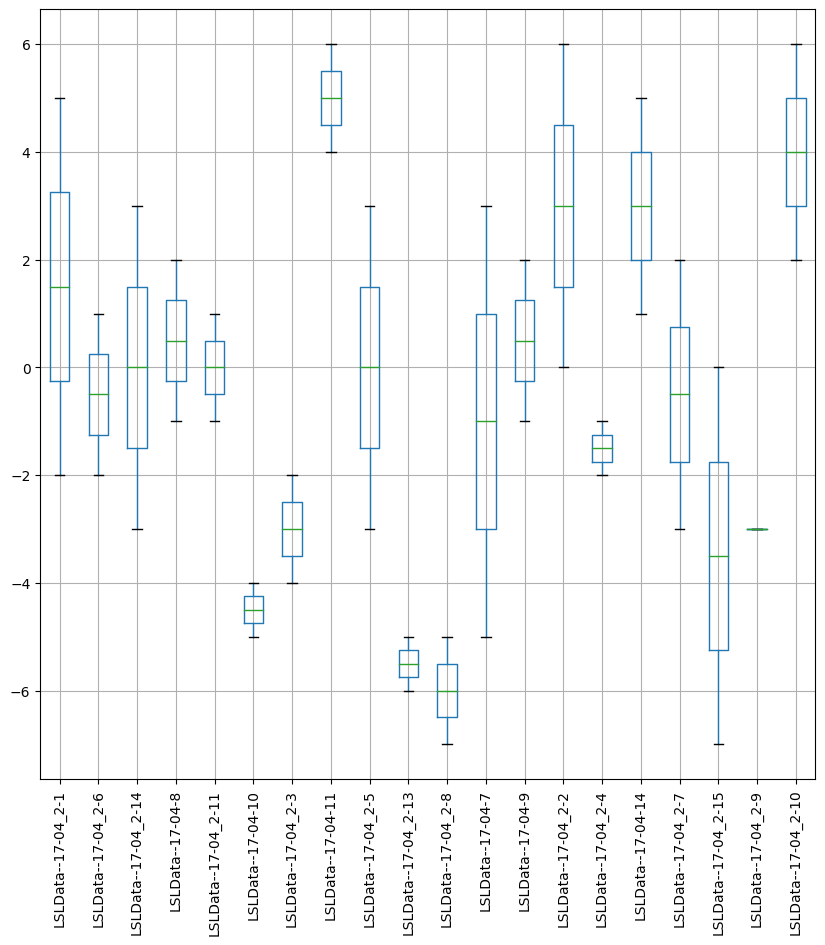

In [17]:
boxplot = df_both_shift.iloc[:, [0, 9]].T.boxplot(figsize=(10,10), rot=90)
